In [12]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

In [13]:
!ls data/

SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv
SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv.7z
X_test.npy
X_test_2.npy
X_train.npy
X_train_2.npy
y_test.npy
y_test_2.npy
y_train.npy
y_train_2.npy


In [14]:
file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21


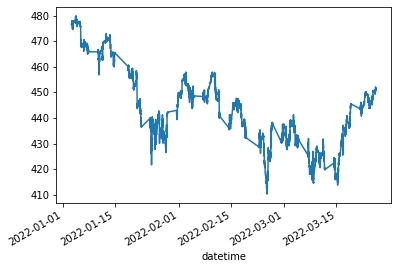

In [15]:
df.set_index('datetime')['close'].plot()

In [16]:
df['time-delta'] = df['datetime'].diff().dt.seconds
for col in ['volume','open','close','high','low']:
    df[f'{col}_diff'] = df[col].pct_change()
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,time-delta,volume_diff,open_diff,close_diff,high_diff,low_diff
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37,300.0,-0.811373,0.000210,-0.000252,-0.000902,0.000126
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80,300.0,4.493251,0.000294,0.000819,0.000797,0.000294
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44,300.0,-0.821542,0.000462,-0.000629,-0.000063,-0.000105
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21,300.0,-0.405049,-0.000398,0.000609,-0.000042,0.000189


In [17]:
df['time-delta'].value_counts().sort_index()

300.0      10856
600.0         49
900.0          1
1200.0         1
25500.0        1
29100.0       56
Name: time-delta, dtype: int64

In [18]:
df = df[1:]

In [19]:
300/60

5.0

In [20]:
600/60

10.0

In [21]:
900/60

15.0

In [22]:
1200/60

20.0

In [23]:
25500/60

425.0

In [24]:
29100/60

485.0

# Creating the feature Matrix

In [25]:
# Window of data we're working with
N = df.shape[0]
print(f'{N} ticks found')

# 2 hour lookback period
LOOKBACK = 2*(60/5)

# Growth requirement
GROWTH_LIMIT = 0.005

# outcome period 30min
HORIZON = 6

X = list()
y = list()

t =1
finish = False
counter = 0
while finish is False:
    
    counter+=1
    print(f'Counter:{counter}',end='\r')
    
    # check we have enough lookback data
    if t<22:
        t+=1
        continue
    
    # check we don't have enough data left then end the cycle
    if (N - t)<5:
        finish = True
        t+=1
        continue
        
    lookback_data = df.loc[t-20:t,['volume_diff','close_diff','open_diff','high_diff','low_diff']].values
    outcome_data = df.loc[t+1:t+6,'close_diff'].sum()>GROWTH_LIMIT
    
    X.append(lookback_data)
    y.append(outcome_data)
    
    t+=1


10964 ticks found


In [26]:
y = np.array(y).reshape(-1,1)
y.shape

(10938, 1)

In [27]:
y.mean()

0.03355275187420004

In [28]:
y.sum()

367

In [29]:
X = np.stack(X)

In [30]:
X.shape

(10938, 21, 5)

In [31]:
X_train = X[:6000]
X_test = X[6000:]

y_train = y[:6000]
y_test = y[6000:]

with open('./data/X_train.npy','wb') as f:
    np.save(f,X_train)
    
with open('./data/X_test.npy','wb') as f:
    np.save(f,X_test)
    
with open('./data/y_train.npy','wb') as f:
    np.save(f,y_train)
    
with open('./data/y_test.npy','wb') as f:
    np.save(f,X_test)

# Defining a simple LSTM

In [32]:
import tensorflow as tf
from tensorflow import keras

In [33]:
X_train.shape

(6000, 21, 5)

In [34]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [35]:
X_train.shape

(6000, 21, 5)

In [65]:
from tensorflow.keras.layers import LSTM
from tensorflow import keras

lookback = 20
model = keras.Sequential([
    keras.layers.LSTM(20,input_shape=(21,5)),
    keras.layers.Dense(5),
    keras.layers.Dense(1,activation='sigmoid')
])

In [66]:
import tensorflow as tf

metrics = [tf.metrics.AUC(name='auc')]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [67]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [68]:
history = model.fit(X_train,y_train,batch_size=50,epochs=10,verbose=2,validation_data=(X_test,y_test))

Train on 6000 samples, validate on 4938 samples
Epoch 1/10


2022-07-31 21:27:44.174651: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_71195_71666' and '__inference___backward_standard_lstm_71195_71666_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_71886' both implement 'lstm_62671b29-88f1-4857-9115-582e9d10d52f' but their signatures do not match.
2022-07-31 21:27:47.489387: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_72440_specialized_for_sequential_11_lstm_11_StatefulPartitionedCall_at___inference_distributed_function_72911' and '__inference_cudnn_lstm_with_fallback_72551' both implement 'lstm_33dcdd39-3ca9-4af7-ad42-0a992af3c0a3' but their signatures do not match.


6000/6000 - 5s - loss: 0.7038 - auc: 0.4559 - val_loss: 0.6701 - val_auc: 0.4941
Epoch 2/10
6000/6000 - 3s - loss: 0.6388 - auc: 0.5395 - val_loss: 0.6079 - val_auc: 0.5212
Epoch 3/10
6000/6000 - 3s - loss: 0.5656 - auc: 0.5737 - val_loss: 0.5207 - val_auc: 0.5173
Epoch 4/10
6000/6000 - 3s - loss: 0.4241 - auc: 0.5427 - val_loss: 0.3103 - val_auc: 0.4942
Epoch 5/10
6000/6000 - 3s - loss: 0.2023 - auc: 0.5074 - val_loss: 0.1739 - val_auc: 0.4714
Epoch 6/10
6000/6000 - 3s - loss: 0.1453 - auc: 0.5529 - val_loss: 0.1634 - val_auc: 0.4723
Epoch 7/10
6000/6000 - 3s - loss: 0.1389 - auc: 0.5478 - val_loss: 0.1622 - val_auc: 0.4659
Epoch 8/10
6000/6000 - 3s - loss: 0.1373 - auc: 0.5460 - val_loss: 0.1621 - val_auc: 0.4798
Epoch 9/10
6000/6000 - 3s - loss: 0.1369 - auc: 0.5393 - val_loss: 0.1622 - val_auc: 0.4731
Epoch 10/10
6000/6000 - 3s - loss: 0.1366 - auc: 0.5405 - val_loss: 0.1622 - val_auc: 0.4718


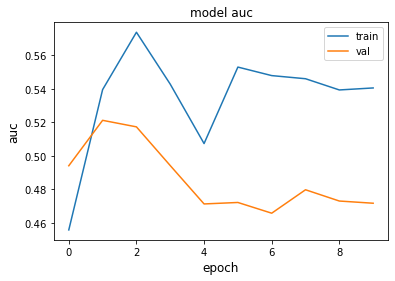

In [69]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

In [32]:
2*0.66-1

0.32000000000000006